# Variational monte carlo simulation for 1D harmonic oscillator.

The local energy equals:  0.508312566605 
With uncertainty:  0.0168350334728


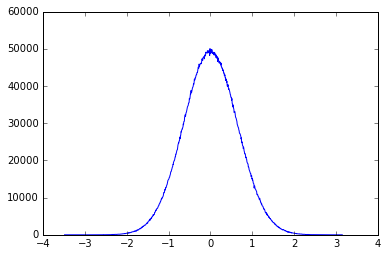

In [79]:
import numpy as np
from matplotlib import pyplot as plt
import math
%matplotlib inline
#Harmonic oscillator local energy
def ElHarm(x, a):
    return a + x * x * (0.5 - 2 * a ** 2)
            
def updateWalkers(w, nWalk, a):
    wNew = np.random.normal(0,math.sqrt(1 / 2 / a), nWalk)
    ratio = np.exp(-2 * a * ((w+wNew) ** 2 - w ** 2)) 
    u = np.random.uniform(size=(nWalk))
    w += (u < ratio) * wNew
            
nWalk = 400
nStep = 30000
a = 0.6
nEquilibriate = 4000

r = np.zeros(nWalk * nStep)
w = np.random.uniform(-math.sqrt(1 / 2 / a),math.sqrt(1 / 2 / a), nWalk) #initiate walkers in uniform distr
    
for i in range(0, nEquilibriate):
    updateWalkers(w, nWalk, a)
    
for i in range(0, nStep):
    updateWalkers(w, nWalk, a)
    r[i * nWalk : (i + 1) * nWalk] = w
    
hist, bin_edges = np.histogram(r,1000)
        
        
        
plt.plot(np.linspace(min(bin_edges),max(bin_edges), len(hist)), hist)


print("The local energy equals: ", np.mean(ElHarm(r, a)), "\nWith uncertainty: ", np.var(ElHarm(r, a)))

# Variational MonteCarlo code for Hydrogen Atom

The local energy equals:  -0.494856674456 
With uncertainty:  0.0119918359487


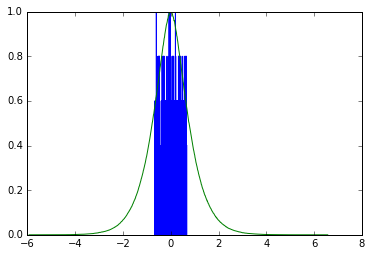

In [86]:
import numpy as np
from matplotlib import pyplot as plt
import math
%matplotlib inline
#Harmonic oscillator local energy
def ElHarm(x, a):
    return a + x * x * (0.5 - 2 * a ** 2)

#hydrogen atom local energy
def ElHydro(x, a):
    g = 1 / np.sqrt(np.sum(x ** 2, axis = 1))
    return -g - 0.5 * a * (a - 2 * g)
            
def updateWalkers(w, nWalk, a):
    d = 0.1 * np.random.normal(0,math.sqrt(1 / 2 / a), (nWalk, 3))
    ratio = np.exp( -2 * a * (np.sqrt(np.sum((w + d) ** 2, axis=1)) - np.sqrt(np.sum(w ** 2, axis=1)))) 
    u = np.random.uniform(size=(nWalk))
    w += (u < ratio)[:,None] * d
            
nWalk = 400
nStep = 30000
a = 1.1
nEquilibriate = 4000

r = np.zeros((nWalk * nStep , 3))
w = np.random.uniform(-math.sqrt(1 / 2 / a),math.sqrt(1 / 2 / a), (nWalk,3)) #initiate walkers in uniform distr
    
hist, bin_edges = np.histogram(w,1000)
plt.plot(np.linspace(min(bin_edges),max(bin_edges), len(hist)), hist / max(hist))
    
for i in range(0, nEquilibriate):
    updateWalkers(w, nWalk, a)
    
for i in range(0, nStep):
    updateWalkers(w, nWalk, a)
    r[i * nWalk : (i + 1) * nWalk, :] = w
    
hist, bin_edges = np.histogram(r,1000)
plt.plot(np.linspace(min(bin_edges),max(bin_edges), len(hist)), hist / max(hist))


print("The local energy equals: ", np.mean(ElHydro(r, a)), "\nWith uncertainty: ", np.var(ElHydro(r, a)))

# VMC for hydrogen molecule

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy.optimize
from IPython.display import clear_output
%matplotlib inline
#x is a 6dimensional vector

#hydrogen molecule local energy
def ElHydro(x, a, s, alpha, beta):
    r1 = x[:,0:3] #position of first electron
    r2 = x[:,3:6] #position of second electron
    sL = [-s / 2, 0, 0] #position of left hydrogen atom
    sR = [s / 2, 0, 0] #position of right hydrogen atom
    r1L = norm(r1, sL)
    r2L = norm(r2, sL)
    r1R = norm(r1, sR)
    r2R = norm(r2, sR)
    r12 = norm(r1, r2)
    phi1L = np.exp(-r1L / a)
    phi1R = np.exp(-r1R / a)
    phi1 = phi1R + phi1L
    phi2L = np.exp(-r2L / a)
    phi2R = np.exp(-r2R / a)
    phi2 = phi2R + phi2L
    
    El = -1 / a ** 2 + 1 / (a * phi1) * (phi1L / r1L + phi1R / r1R)
    El += 1 / (a * phi2) * (phi2L / r2L + phi2R / r2R)
    El -= (1 / r1L + 1 / r1R + 1 / r2L + 1 / r2R)
    El += 1 / r12
    El += np.sum(((phi1L[:,None] * (r1 - sL) / r1L[:,None] + phi1R[:,None] * (r1 - sR) / r1R[:,None]) / phi1[:,None] - (phi2L[:,None] * (r2 - sL) / r2L[:,None] + phi2R[:,None] * (r2 - sR) / r2R[:,None]) / phi2[:,None] ) * ((r1 - r2) / r12[:,None] / (2 * a * (1 + beta * r12[:,None]) ** 2)), axis = 1)
    El -= ((4 * beta + 1) * r12 + 4) / (4 * (1 + beta * r12) ** 4 * r12)
    
    return El
       
def updateWalkers(w, nWalk, a, s, alpha, beta):
    d = 0.1 * np.random.normal(0,math.sqrt(a), (nWalk, 6))
    ratio = calcPsi(w + d, a, s, alpha, beta) ** 2 / calcPsi(w , a, s, alpha, beta) ** 2
    u = np.random.uniform(size=(nWalk))
    w += (u < ratio)[:,None] * d
    
def calcPsi(x, a, s, alpha, beta):
    r1 = x[:,0:3] #position of first electron
    r2 = x[:,3:6] #position of second electron
    sL = [-s / 2, 0, 0] #position of left hydrogen atom
    sR = [s / 2, 0, 0] #position of right hydrogen atom
    r1L = norm(r1, sL)
    r2L = norm(r2, sL)
    r1R = norm(r1, sR)
    r2R = norm(r2, sR)
    r12 = norm(r1, r2)
    phi1L = np.exp(-r1L / a)
    phi1R = np.exp(-r1R / a)
    phi1 = phi1R + phi1L
    phi2L = np.exp(-r2L / a)
    phi2R = np.exp(-r2R / a)
    phi2 = phi2R + phi2L
    
    return phi1 * phi2 * np.exp(r12 / (alpha * (1 + beta * r12)))
#norm over second axis
def norm(x, y):
    return np.sqrt(np.sum((x - y) ** 2, axis = 1))

def dPsidBeta(w, alpha, beta):
    r12  = np.linalg.norm(w[:, 0:3] - w[:,3:6], axis=1)
    return -(r12 ** 2) / (alpha * (1 + beta * r12) ** 2)

def fAFromS(a, *args):
    s = args
    return a * (1 + np.exp(s / a)) - 1
      
def runMonteCarlo(nWalk, nStep, nEquilibriate, s, beta, plotPos = False):
    #start of program----------------------------------------------------
    #Calculates estimates for local energy based on fixed parameters

    #Retrieve the 2 dependent parameters from independent s, beta:
    alpha = 2
    a = 1 / (2 * s) #linearized crusp condition(gives a first estimate for a)
    a = scipy.optimize.fsolve(fAFromS,a, args = (s)) #solve for a better estimate of a
    print('a = ', a)

    #initiate the walker positions
    w = np.zeros((nWalk, 6))
    ElMean = 0
    ElMean2 = 0
    ElPsiMean = 0 #used in beta optimization
    dPsiMean = 0 #used in beta optimization
    Elvars = np.zeros((nStep))
    w[:,0] = np.random.normal(-s / 2, math.sqrt(a), (nWalk)) #initiate walkers of first electron in normal distr x-coordinate
    w[:,3] = np.random.normal(s / 2, math.sqrt(a), (nWalk))  #initiate walkers of 2nd el. x coordinate
    w[:,[1,2,4,5]] = np.random.normal(0,math.sqrt(a), (nWalk,4))  #initiate walkers in normal distribution of y and z coordinates.  

    #start of looping: first equilibriate the walkers
    for i in range(0, nEquilibriate):
        updateWalkers(w, nWalk, a, s, alpha, beta)
    
    #----------------------------------------------------------------
    #optional plotting part
    if(plotPos):
        f, axarr = plt.subplots(2, 3, figsize = (20,12))
        nBins = 400
        pos = np.zeros((nBins,6))
        edges = np.zeros((nBins + 1,6))
        for i in range(0,6):
            pos, edges = np.histogram(w[:,i],nBins)
            axarr[(i) / 3, int((-(i) / 3)) * 3 + i].plot(edges[0:-1] + np.diff(edges, axis = 0) / 2, pos)
            axarr[(i) / 3, int((-(i) / 3)) * 3 + i].set_title("w[%d]" % (i))
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,9))
        ax1.scatter(w[:,0], w[:,1])
        ax1.set_xlim(-10,10)
        ax1.set_ylim(-10,10)
        ax1.set_xlabel('xposition first electron')
        ax1.set_ylabel('ypos first electron')
        ax2.scatter(w[:,3], w[:,4])
        ax2.set_xlim(-10,10)
        ax2.set_ylim(-10,10)
        ax2.set_xlabel('xposition second electron')
        ax2.set_ylabel('ypos second electron')
        print('avg x position of first electron: ', np.mean(w[:,0]))
        print('avg x position of second electron', np.mean(w[:,3]))
        
    #--------------------------------------------------------------------
    
    #now start the actual iterations determined by nStep.
    for i in range(0, nStep):
        updateWalkers(w, nWalk, a, s, alpha, beta)
        #now update means of needed variables in order to save memory
        El = ElHydro(w, a, s, alpha, beta)
        dPsi = dPsidBeta(w, alpha, beta)
        ElMean = i / (i + 1) * ElMean + 1 / (i + 1) * np.mean(El)
        ElMean2 =  i / (i + 1) * ElMean2 + 1 / (i + 1) * np.mean(El ** 2)
        ElPsiMean = i / (i + 1) * ElPsiMean + 1 / (i + 1) * np.mean(El * dPsi)
        dPsiMean = i / (i + 1) * dPsiMean + 1 / (i + 1) * np.mean(dPsi)
    Elstd = np.sqrt(ElMean2 - ElMean)
    return ElMean, Elstd, ElPsiMean, dPsiMean

C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:108: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


a =  [ 1.09496128]
avg x position of first electron:  -0.0552433014357
avg x position of second electron 0.0383658204218
The local energy equals:  -1.75375710428 
With standard deviation:  0.00338920487909


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:109: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


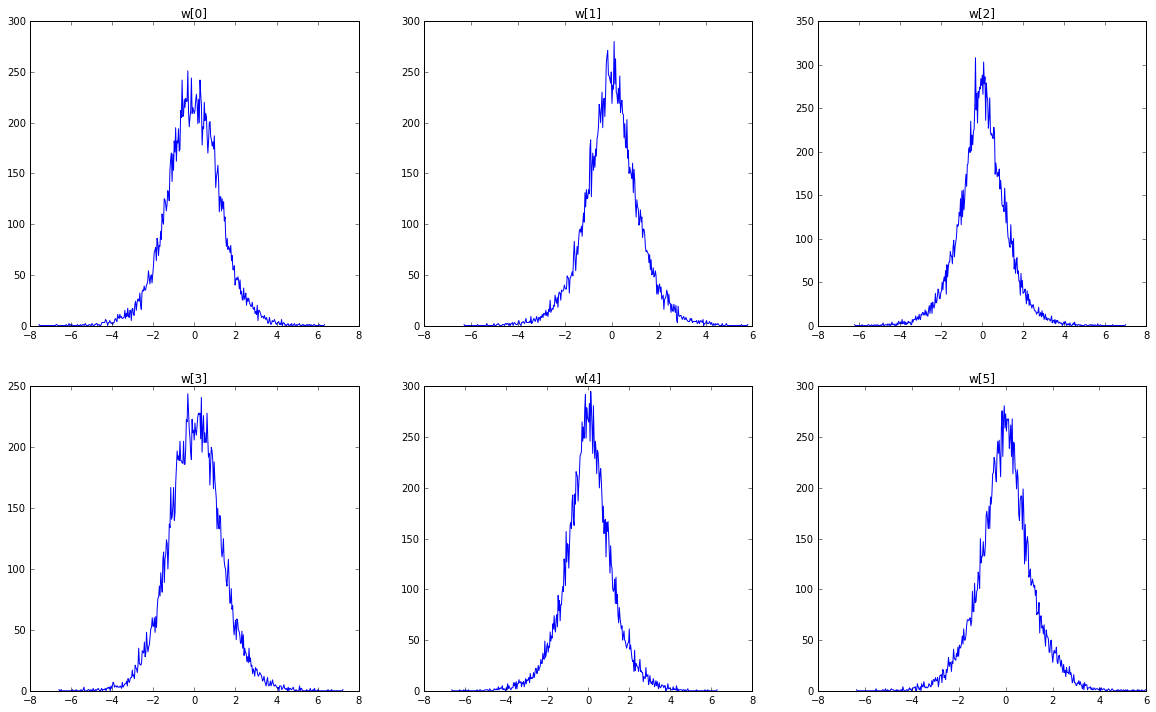

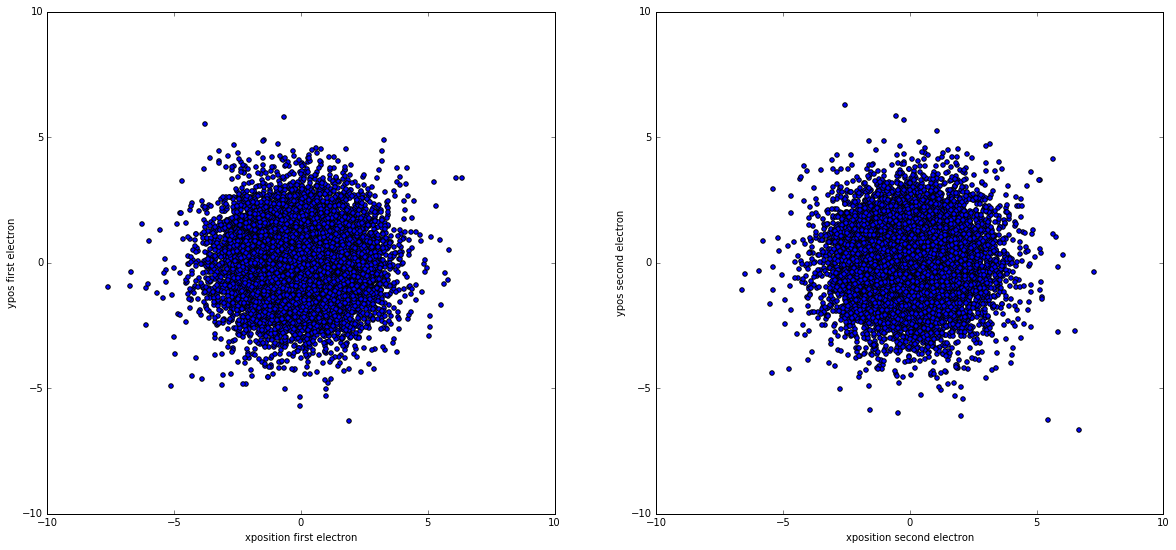

In [249]:
Elmean, ElVar, ElPsiMean, dPsiMean = runMonteCarlo(nWalk = 20000, nStep = 1, nEquilibriate = 1000, s = 1.4, beta = 0.6, plotPos = True)
print("The local energy equals: ", Elmean, "\nWith standard deviation: ", Elstd)

## Optimization over Beta

In [119]:
nIt = 10
Els = np.zeros((nIt))
ElStds = np.zeros((nIt))
betas = np.zeros((nIt + 1))
gamma = 0.8
betas[0] = 1
for i in range(0,nIt):
    print('Calculating step ', i)
    Els[i], ElStds[i], ElPsiMean, dPsiMean = runMonteCarlo(nWalk = 1000, nStep = 10000, nEquilibriate = 1000, s = 1.4, beta = betas[i])
    #now calculate derivative to beta
    betas[i+1] = betas[i] - gamma * 2 * (ElPsiMean - Els[i] * dPsiMean)
    





Calculating step  0
Calculating step  1
Calculating step  2
Calculating step  3
Calculating step  4
Calculating step  5
Calculating step  6
Calculating step  7
Calculating step  8
Calculating step  9


C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


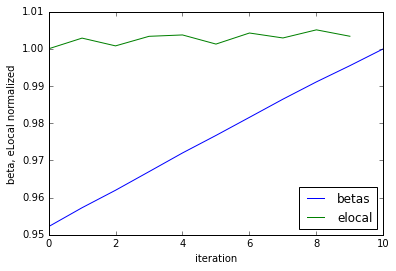

In [120]:
plt.plot(range(0,nIt+1), betas / max(betas))
plt.plot(range(0,nIt), Els / max(Els))
plt.xlabel('iteration')
plt.ylabel('beta, eLocal normalized')
plt.legend(('betas', 'elocal'), loc= 'best')

In [121]:
print(ElStds)
print(Els)

[ 1.86298038  1.86684788  1.86423124  1.86789633  1.86911119  1.86470691
  1.86888352  1.86723117  1.87076288  1.86798672]
[-1.39846476 -1.40248326 -1.39956343 -1.40315701 -1.40367315 -1.4002415
 -1.40440044 -1.4025413  -1.40558841 -1.40317928]


In [122]:
print(betas)

[ 1.          1.0053374   1.01027166  1.01551876  1.02079789  1.02574707
  1.03085362  1.03598267  1.04086571  1.04544199  1.0502046 ]


In [123]:
print(np.diff(betas))

[ 0.0053374   0.00493426  0.0052471   0.00527913  0.00494918  0.00510655
  0.00512905  0.00488304  0.00457628  0.00476261]


In [240]:
x = np.array([[1, 2, 3, 4, 5, 6],[11,22,33,44,55,66]])

In [8]:
%matplotlib 

Using matplotlib backend: Qt4Agg


In [9]:
from mpl_toolkits.mplot3d import Axes3D
s = 1.4
n = 100
x1 = np.linspace(-s,s,n)
x2 = np.linspace(-s,s,n)
X, Y = np.meshgrid(x1,x2)
Z = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        Z[i,j] = calcPsi(np.array([[x1[i],0,0,x2[j],0,0]]), 1.06, 1.4, 2, 0.6)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z)